# Overview

These sections match the marking scheme. Each heading indicates the marks for each and type of content that should be included (either Markdown or Code). You can prepare markdown sections  in Microsoft Word, but remember to change the cell type to 'Markdown' so the cell is not executed as code. (See: <a href="https://www.markdownguide.org/basic-syntax/">Markdown<a/>)

1. Rename the Notebook replacing the words '_KF7032_Template_' with your user id (something like w12345678_KF7032)
2. Before you submit the final version of your notebook, you should delete all output, and then run all cells. This checks that your program is consistent.
3. Finally download the notebooks as an __.ipynb file__ for assessment, and also as an __html file__ that will readable by examiners who do not have Jupyter.
4. Sections identified as Markdown should be at least one paragraph of text. The total word limit for markdown is 2500 words

# 1) Introduction: The Crime Analysis task ..._Markdown_, **10 Marks**, Max 300 Words

This section should be written in markdown.

    1. Give the background to the "Drugs and Guns" project. Use the academic literature to motivate the work. Remember to cite papers you are using.
    2. Give the aims and objectives of the project in your own words. (Do not copy the assignment spec)
    3. Outline the technical approach (what you plan to do)

Claims that an increase in violence in the UK, specifically so within gun and knife crime, are not unfounded, with parts of the UK experiencing a rise in reported gun and knife crime; and Brexit threatening UK correspondence with EU organisations set up to tackle this problem [1]. Drug offences are more relatively stable, albeit at a constant high level, with the UK having the highest level of drug dependence and one of the highest levels of recreational drug use in all of Europe [2, 3].

The primary objective of the project is to verify and evaluate claims made in the TV documentary “Ross Kemp and the Armed Police”. The claims are from the 6/9/2018 broadcast, stating that violent crime is increasing, that there are more firearm incidents per head in Birmingham than anywhere else in the UK, and that crimes involving firearms are closely associated with drug offences. The extent to which the data supports or contradicts the claims will be analysed and evaluated.

UK Government provided data will be used to do this, primarily constituted of a large dataset of crimes within the UK, including the date and type of crime, location coordinates and the outcome. Several other datasets will be used in conjunction, including a dataset of UK postcodes and their coordinates as well as UK postcodes with their district and population.

Using this data together, the dataset of crimes can be filtered data only to relevant crimes, with the crime location extracted. This can be converted to a postcode and further to a district using the second and third datasets respectively. The third dataset also contains information about population at a given postcode, and by extension district, all together providing crimes per population in each district. Trends in violent crime can be observed by plotting violent crimes as a timeseries. Lastly, any association between firearms and drugs can be identified by the correlation coefficient from an appropriate regression correlation algorithm.


# 2) Component Selection and Data Pipeline Implementation _code_	**10 Marks**

In this section you will have one or more code cells. These will include your library imports. You will also access the data efficiently using Apache Spark on a cloud Infrastructure as a Service (IaaS) platform. (NB Google colab is SaaS -- not IaaS)

To speed your subsequent development you may want to initially use a subset of the data so could process that here.

In [1]:
# Import packages
# pandas for fast, local dataframes and display
import pandas as pd

# pyspark for spark integration 
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, FloatType, DateType, IntegerType
from pyspark.sql.functions import col, regexp_replace, sum, round as sparkRound, split, coalesce

# matplotlib for graphing
import matplotlib.pyplot as plt
from matplotlib.dates import date2num

# pathlib's Path for more robustly checking if a file exists (very lightweight)
from pathlib import Path

# seaborn for more complex graphing, regplot for line of best fit
from seaborn import regplot
#scipy for more verbose spearman and pearson functions
from scipy.stats import spearmanr, pearsonr

# NumPy's percentile function
from numpy import percentile

In [2]:
#Initialise session
spark = SparkSession\
    .builder\
    .appName("Python Spark")\
    .getOrCreate()


#Suppress warnings about schema being different to the file header
spark.sparkContext.setLogLevel("ERROR")

In [3]:
class data:
# Create a funtion to accept a dataframe with longitude and latitude columns, as well as an integer of how many decimal places
# the numbers should be rounded to. The dataframe is returned with all columns, with the new longitude and latitude columns
# in place of the old ones.
    def roundLongLat(dataframe, decimals):
        if("Longitude" in dataframe.columns and "Latitude" in dataframe.columns):
            return dataframe \
            .select("*",sparkRound("Longitude", decimals)) \
            .select("*",sparkRound("Latitude", decimals)) \
            .drop("Longitude", "Latitude") \
            .withColumnRenamed("round(Longitude, {0})".format(decimals), "Longitude") \
            .withColumnRenamed("round(Latitude, {0})".format(decimals), "Latitude")
        else:
            raise Exception("Longitude or Latitude column is not present")
    
    
#Function to read the data of a given path, schema, with a header attribute as not all datasets do or do not have one.
#Header is assumed true but can be specified
    def read_data(data_path, schema, header = "true"):
        if (Path(data_path).is_file()):
            dataframe = spark.read.load(data_path, \
                    format="csv", \
                    sep=",", \
                    schema=schema, \
                    header=header)
            
            if("Longitude" in dataframe.columns and "Latitude" in dataframe.columns):
                dataframe = data.roundLongLat(dataframe, LONG_LAT_ROUNDING)
                
            return dataframe
        
        else:
            raise Exception("File {0} does not exist".format(data_path))
            
# Create a function to accept a dataframe, that returns a pandas dataframe with the index as a timeseries.
# Function assumes there is a column called Date, that is selected, used to group the dataframe, counted, reformatted to
# a pandas dataframe and as the index. A two column dataframe is always returned. 
# The index is the date, in order from oldest to newest, with a corresponding frequency column (a frequency timeseries).

    def toTimeseries(dataframe):
        if ("Date" in dataframe.columns):
            return dataframe.select("Date") \
            .groupBy("Date") \
            .count() \
            .orderBy("Date") \
            .toPandas() \
            .rename(columns={"count": "Frequency"}) \
            .set_index("Date")
        else:
            raise Exception("Dataframe has no \"Date\" Column")

In [4]:
#location of the datasets, change as necessary
# sample and full datasets changed by comments

# CRIME_FILE_PATH = "./data/Sample_1pc_Data.csv"
CRIME_FILE_PATH = "./data/all_crimes21_hdr.txt"
POSTCODE_FILE_PATH = "./data/postcodes.csv"
LONG_LAT_POSTCODE_FILE_PATH = "./data/posttrans.csv"

#static value for how much the long/lat values should be rounded. This needs to be consistent for comparison.
LONG_LAT_ROUNDING = 4

Load crime data, select useful columns, rename month to date and display a small sample. Contains all crimes, locations and outcomes. This is the main data.

In [5]:
#schema for the crime data dataset
crimeSchema = StructType([ \
    StructField("Crime ID",StringType(),True), \
    StructField("Date",DateType(),False), \
    StructField("Reported by",StringType(),True), \
    StructField("Falls within", StringType(), True), \
    StructField("Longitude", FloatType(), True), \
    StructField("Latitude", FloatType(), True), \
    StructField("Location", StringType(), True), \
    StructField("LSOA code", StringType(), True), \
    StructField("LSOA name", StringType(), True), \
    StructField("Crime type", StringType(), False), \
    StructField("Last outcome category", StringType(), True), \
    StructField("Context", StringType(), True) \
  ])

#load crime data
df = data.read_data(CRIME_FILE_PATH, crimeSchema, header = "true")

#select only necessary data
df = df.select("Date", "Longitude", "Latitude", "Crime type", "Last outcome category")

#display a sample
df.show(5, truncate=False)

+----------+---------+--------+---------------------+---------------------+
|Date      |Longitude|Latitude|Crime type           |Last outcome category|
+----------+---------+--------+---------------------+---------------------+
|2010-12-01|-0.8056  |51.8191 |Other crime          |null                 |
|2010-12-01|-2.4944  |51.4182 |Anti-social behaviour|null                 |
|2010-12-01|-2.5119  |51.4094 |Anti-social behaviour|null                 |
|2010-12-01|-2.5116  |51.4149 |Anti-social behaviour|null                 |
|2010-12-01|-2.5119  |51.4094 |Anti-social behaviour|null                 |
+----------+---------+--------+---------------------+---------------------+
only showing top 5 rows



Same for postcode/district data. Used to get district and population info

In [6]:
#schema for the postcode dataset
postcodeSchema = StructType([ \
    StructField("Postcode",StringType(),False), \
    StructField("InUse?",StringType(),True), \
    StructField("Latitude",StringType(),True), \
    StructField("Longitude", StringType(), True), \
    StructField("Easting", StringType(), True), \
    StructField("Northing", StringType(), True), \
    StructField("GridRef", StringType(), True), \
    StructField("County", StringType(), True), \
    StructField("District", StringType(), True), \
    StructField("Ward", StringType(), True), \
    StructField("DistrictCode", StringType(), True), \
    StructField("WardCode", StringType(), True), \
    StructField("Country", StringType(), True), \
    StructField("CountyCode", StringType(), True), \
    StructField("Constituency", StringType(), True), \
    StructField("Introduced", StringType(), True), \
    StructField("Terminated", StringType(), True), \
    StructField("Parish", StringType(), True), \
    StructField("NationalPark", StringType(), True), \
    StructField("Population", IntegerType(), True), \
    StructField("Households", StringType(), True), \
    StructField("BuiltUpArea", StringType(), True), \
    StructField("Builtupsubdivision", StringType(), True), \
    StructField("Lowerlayersuperoutputarea", StringType(), True), \
    StructField("Rural/urban", StringType(), True), \
    StructField("Region", StringType(), True), \
    StructField("Altitude", StringType(), True) \
])

#load postcode data
df_postcode = data.read_data(POSTCODE_FILE_PATH, postcodeSchema, header = "false")
df_postcode = df_postcode.select("Postcode", "Longitude", "Latitude", "District", "Population")
df_postcode.show(5, truncate=False)

+--------+---------+--------+-------------+----------+
|Postcode|Longitude|Latitude|District     |Population|
+--------+---------+--------+-------------+----------+
|AB1 0AA |-2.2429  |57.1015 |Aberdeen City|null      |
|AB1 0AB |-2.2463  |57.1026 |Aberdeen City|null      |
|AB1 0AD |-2.2483  |57.1006 |Aberdeen City|null      |
|AB1 0AE |-2.2557  |57.0844 |Aberdeenshire|null      |
|AB1 0AF |-2.2581  |57.0967 |Aberdeen City|null      |
+--------+---------+--------+-------------+----------+
only showing top 5 rows



Same for long/lat postcode data. Used to convert between a long lat and postcode later

In [7]:
#schema for the long lat postcode dataset
longLatPostSchema = StructType([ \
    StructField("Postcode",StringType(),False), \
    StructField("Longitude",FloatType(),False), \
    StructField("Latitude",FloatType(),False) \
  ])

#load long lat postcode dataset
df_LongLatToPostcode = data.read_data(LONG_LAT_POSTCODE_FILE_PATH, longLatPostSchema, header = "true")

#display a sample of the long lat postcode dataset
df_LongLatToPostcode.show(5, truncate=False)

+--------+---------+--------+
|Postcode|Longitude|Latitude|
+--------+---------+--------+
|HP20 1BL|-0.8056  |51.8191 |
|BS31 2BT|-2.4944  |51.4182 |
|BS31 2PJ|-2.5119  |51.4094 |
|BS31 2EG|-2.5116  |51.4149 |
|BS31 2LQ|-2.5133  |51.4095 |
+--------+---------+--------+
only showing top 5 rows



# 3) Data Extraction and Filtering ... _code_, 10 Marks
### includes System running, test and diagnostics, 

1.	Filter the dataset so that crimes refer to appropriate crimes only
2.  To see whether crime categories are increasing, you will also need to extract them as a time series.

You should be using diagnostic checks throughout this report.

In [8]:
# Create a dataframe of all violent crimes (both "violent crime" and "violence and sexual offences") - this was changed in 2013.
# Combine the data into a single dataframe, group by date, order it as a timeseries and use the date as the dataframe index.
# This allows for significantly easier processing when displaying this as a timeseries graph later.

df_violence_timeseries = data.toTimeseries( \
                        df.filter((col("Crime type") == "Violent crime") |
                                  (col("Crime type") == "Violence and sexual offences")))

#display a sample of the pandas dataframe
display(df_violence_timeseries)

,Frequency
Date,
2010-12-01,57580
2011-01-01,59823
2011-02-01,56691
2011-03-01,62326
2011-04-01,64299
...,...
2021-01-01,141414
2021-02-01,135101
2021-03-01,166668


In [9]:
# get crime data classified only as "violent crime", rather than both "violent crime" and "violence and sexual offences"
df_just_violence_timeseries = data.toTimeseries( \
                        df.filter(col("Crime type") == "Violent crime"))

#display a sample of the pandas dataframe
display(df_just_violence_timeseries[:5])

,Frequency
Date,
2010-12-01,57580
2011-01-01,59823
2011-02-01,56691
2011-03-01,62326
2011-04-01,64299


In [10]:
#As per the assignment brief, a "firearms incident" is defined by a "possession of weapons" whose outcome is
#"offender sent to prison". This is further narrowed to include only incidents where the longitude and latitude is also present

# df_firearms is a dataframe containing the date and location of all firearms incidents.

# filter only firearm incidents
df_firearms_total = df.filter((col("Crime type") == "Possession of weapons") &
                       (col("Last outcome category") == "Offender sent to prison")) \
                .select("Date", "Longitude", "Latitude") \
                .orderBy("Date")


# filter to only include firearm incidents that have a location
df_firearms = df_firearms_total.filter((col("Longitude").isNull() == False) &
                        (col("Latitude").isNull() == False))

# count how many incidents were dropped
total_firearm_incidents = df_firearms_total.count()
total_firearm_incidents_long_lat = df_firearms.count()

# show a sample of the dataframe
df_firearms.show(5, truncate=False)

# nicely display number of incidents, and how many were dropped
print("Total firearms incidents: {0}".format(total_firearm_incidents))
print("Total firearms incidents that provide a longitude and latitude: {0}".format(total_firearm_incidents_long_lat))
print("{0} firearm incidents did not provide a long/lat location. Ignoring these from the dataset.".format(total_firearm_incidents - total_firearm_incidents_long_lat))

+----------+---------+--------+
|Date      |Longitude|Latitude|
+----------+---------+--------+
|2013-05-01|-2.5953  |51.4907 |
|2013-05-01|-2.5167  |51.4765 |
|2013-05-01|-2.576   |51.4705 |
|2013-05-01|-2.5698  |51.4661 |
|2013-05-01|-2.5672  |51.4635 |
+----------+---------+--------+
only showing top 5 rows

Total firearms incidents: 10416
Total firearms incidents that provide a longitude and latitude: 10122
294 firearm incidents did not provide a long/lat location. Ignoring these from the dataset.


In [11]:
# df_drugs is a dataframe containing the date and location of all drug crimes.

# filter only drug crimes
df_drugs_total = df.filter(col("Crime type") == "Drugs") \
                .select("Date", "Longitude", "Latitude") \
                .orderBy("Date")

# filter to only include drug crimes that have a location
df_drugs = df_drugs_total.filter((col("Longitude").isNull() == False) &
                        (col("Latitude").isNull() == False))

# count how many incidents were dropped
total_drug_incidents = df_drugs_total.count()
total_drugs_incidents_long_lat = df_drugs.count()

# show a sample of the dataframe
df_drugs.show(5, truncate=False)

# nicely display number of incidents, and how many were dropped
print("Total drug incidents: {0}".format(total_drug_incidents))
print("Total drug incidents that provide a longitude and latitude: {0}".format(total_drugs_incidents_long_lat))
print("{0} drug incidents did not provide a long/lat location. Ignoring these from the dataset.".format(total_drug_incidents - total_drugs_incidents_long_lat))

+----------+---------+--------+
|Date      |Longitude|Latitude|
+----------+---------+--------+
|2011-09-01|-7.2733  |54.5379 |
|2011-09-01|-6.2764  |54.8557 |
|2011-09-01|-6.3308  |54.4711 |
|2011-09-01|-6.7029  |54.5354 |
|2011-09-01|-6.0252  |54.5603 |
+----------+---------+--------+
only showing top 5 rows

Total drug incidents: 1682486
Total drug incidents that provide a longitude and latitude: 1636770
45716 drug incidents did not provide a long/lat location. Ignoring these from the dataset.


In [12]:
# convert pyspark dataframe with date column to a frequency timeseries pandas dataframe, categorised and indexed by date
df_firearms_timeseries = data.toTimeseries(df_firearms_total)

#same thing for drugs
df_drugs_timeseries = data.toTimeseries(df_drugs_total)

#display samples of the pandas dataframes
print("Firearms:")
display(df_firearms_timeseries[:5])
print("Drugs:")
display(df_drugs_timeseries[:5])

Firearms:


,Frequency
Date,
2013-05-01,182
2013-06-01,162
2013-07-01,161
2013-08-01,186
2013-09-01,174


Drugs:


,Frequency
Date,
2011-09-01,16926
2011-10-01,18448
2011-11-01,18267
2011-12-01,17366
2012-01-01,18199


In [13]:
#select only the postcode, district and population columns, and disregard any null population values.
#only these fields are required, and null population values are of no use.

df_postcode_district_pop = df_postcode.select("Postcode", "District", "Population") \
        .filter(col("Population").isNull() == False)

print("Postcodes and their corresponding district and population")
df_postcode_district_pop.show(5, truncate = False)

Postcodes and their corresponding district and population
+--------+-------------+----------+
|Postcode|District     |Population|
+--------+-------------+----------+
|AB10 1AJ|Aberdeen City|0         |
|AB10 1AL|Aberdeen City|0         |
|AB10 1AN|Aberdeen City|1         |
|AB10 1AP|Aberdeen City|0         |
|AB10 1AS|Aberdeen City|0         |
+--------+-------------+----------+
only showing top 5 rows



In [14]:
# select only the district and population, ensure neither are null, and sum all populations in a single district
# rename the columns sensibly, order the table and display a sample. This allows for easier processing for the firearms
# incidents *per head* in Birmingham compared to other districts.

df_district_population = df_postcode.select("District", "Population") \
        .filter((col("Population").isNull() == False) &
               (col("District").isNull() == False)) \
        .groupBy("District") \
        .sum() \
        .withColumnRenamed("sum(Population)", "Population") \
        .withColumnRenamed("District", "_District") \
        .orderBy("Population", ascending = False)

print("Population per district in the UK")
df_district_population.show(5, truncate = False)

Population per district in the UK
+------------+----------+
|_District   |Population|
+------------+----------+
|Birmingham  |1072849   |
|Leeds       |751490    |
|Glasgow City|592799    |
|Sheffield   |552744    |
|Cornwall    |532285    |
+------------+----------+
only showing top 5 rows



In [15]:
# count all people in the UK, as well as all people when null districts are removed. Display the difference.
# Null districts have to be removed, and the difference is to see how much data was lost as a result of this.

total_population = df_postcode_district_pop.select(sum('Population')).collect()[0][0]
total_population_NoNulls = df_district_population.select(sum('Population')).collect()[0][0]
print("Total Population of the UK is {0}".format(total_population))
print("Total Population of the UK, disregarding null districts, is {0}".format(total_population_NoNulls))
print("This is a difference of {0}".format(total_population - total_population_NoNulls))

Total Population of the UK is 63138237
Total Population of the UK, disregarding null districts, is 61365808
This is a difference of 1772429


In [16]:
# Rename columns to be individually dropped later
df_firearms = df_firearms.withColumnRenamed("Date", "Firearm_Date")

df_drugs = df_drugs.withColumnRenamed("Date", "Drug_Date") \
                    .withColumnRenamed("Longitude", "Drug_Longitude") \
                    .withColumnRenamed("Latitude", "Drug_Latitude")

# create a dataframe of all the dates and locations where both a drug offence and a firearms offence occurred.
df_correlation_Date_Long_Lat = df_firearms.join(df_drugs, \
                                        (df_firearms.Firearm_Date == df_drugs.Drug_Date) &
                                        (df_firearms.Longitude == df_drugs.Drug_Longitude) &
                                        (df_firearms.Latitude == df_drugs.Drug_Latitude)) \
                                        .drop("Drug_Date", "Drug_Longitude", "Drug_Latitude")

num_firearm_offences = df_firearms.count()
num_drug_offences = df_drugs.count()
num_correlated_offences = df_correlation_Date_Long_Lat.count()

print("Total Firearms incidents: {0}" \
      .format(num_firearm_offences))
print("Total Drugs incidents: {0}" \
      .format(num_drug_offences))
print("Total Incidents of both firearms and drugs at the same location in the same timeframe: {0}" \
      .format(num_correlated_offences))

Total Firearms incidents: 10122
Total Drugs incidents: 1636770
Total Incidents of both firearms and drugs at the same location in the same timeframe: 4768


In [17]:
# count all firearm incidents that occurred in the same location in the same timeframe
df_firearms_freq = df_firearms.groupBy(["Firearm_Date", "Longitude", "Latitude"]) \
                                .count() \
                                .orderBy("count", ascending = False)
df_firearms_freq = df_firearms_freq.withColumnRenamed("count", "Firearm Incidents")

# same for drugs
df_drugs_freq =  df_drugs.groupBy(["Drug_Date", "Drug_Longitude", "Drug_Latitude"]) \
                            .count() \
                            .orderBy("count", ascending = False)
df_drugs_freq = df_drugs_freq.withColumnRenamed("count", "Drug Incidents")

# same for dataframe containing both
df_correlation_Date_Long_Lat_Freq = df_correlation_Date_Long_Lat.groupBy(["Firearm_Date", "Longitude", "Latitude"]) \
                                                                .count() \
                                                                .orderBy("count", ascending = False)
                                                                
df_correlation_Date_Long_Lat_Freq = df_correlation_Date_Long_Lat_Freq.withColumnRenamed("count", "Both")


# create a dataframe of all the dates and locations where both a drug offence and a firearms offence occurred.
df_correlation_frequency = df_firearms_freq.join(df_drugs_freq, \
                                        (df_firearms_freq.Firearm_Date == df_drugs_freq.Drug_Date) &
                                        (df_firearms_freq.Longitude == df_drugs_freq.Drug_Longitude) &
                                        (df_firearms_freq.Latitude == df_drugs_freq.Drug_Latitude), how="full")


df_correlation_frequency = df_correlation_frequency.join(df_correlation_Date_Long_Lat_Freq, \
                                        (df_firearms_freq.Firearm_Date == df_correlation_Date_Long_Lat_Freq.Firearm_Date) &
                                        (df_firearms_freq.Longitude == df_correlation_Date_Long_Lat_Freq.Longitude) &
                                        (df_firearms_freq.Latitude == df_correlation_Date_Long_Lat_Freq.Latitude), how="full")


df_correlation_frequency = df_correlation_frequency.select("Firearm Incidents", "Drug Incidents", "Both").fillna(value=0)

In [18]:
# drop any postcodes with the same long/lat as another postcode. This was causing inflated matching issues -
# (matching more addresses than there was crimes)
df_LongLatToPostcode = df_LongLatToPostcode.dropDuplicates(["Longitude", "Latitude"])

#match all incidents to their corresponding postcodes. This is done to extract the district from the postcode
# and therefore the district of the crime
df_firearm_incidents_postcode = df_LongLatToPostcode.join(df_firearms, \
                                            (df_LongLatToPostcode.Longitude == df_firearms.Longitude) &
                                            (df_LongLatToPostcode.Latitude == df_firearms.Latitude)) \
                                            .select("Postcode")

df_firearm_incidents_postcode = df_firearm_incidents_postcode \
                                    .withColumn('code', split(df_firearm_incidents_postcode['Postcode'], ' ') \
                                    .getItem(0)) \
                                    .select("code") \
                                    .withColumnRenamed("code", "Postcode")

#display a small sample of the data
df_firearm_incidents_postcode.show(5, truncate=False)

#These numbers should be exactly the same. Second one higher = duplicate rounding issue, lower = rounding to too many places
#Should never be higher as any duplicate long/lat's for different postcodes are dropped
print("Number of firearms incidents: {0}".format(df_firearms.count()))
print("Number of firearm incidents mapped to postcodes: {0}".format(df_firearm_incidents_postcode.count()))

+--------+
|Postcode|
+--------+
|BS22    |
|BS22    |
|CH3     |
|L20     |
|L13     |
+--------+
only showing top 5 rows

Number of firearms incidents: 10122
Number of firearm incidents mapped to postcodes: 10120


In [19]:
#match all incidents to their corresponding postcodes. This is done to extract the district from the postcode
# and therefore the district of the crime
df_drug_incidents_postcode = df_LongLatToPostcode.join(df_drugs, \
                                            (df_LongLatToPostcode.Longitude == df_drugs.Drug_Longitude) &
                                            (df_LongLatToPostcode.Latitude == df_drugs.Drug_Latitude)) \
                                            .select("Postcode")

df_drug_incidents_postcode = df_drug_incidents_postcode \
                                    .withColumn('code', split(df_drug_incidents_postcode['Postcode'], ' ') \
                                    .getItem(0)) \
                                    .select("code") \
                                    .withColumnRenamed("code", "Postcode")

#display a small sample of the data
df_drug_incidents_postcode.show(5, truncate=False)

#These numbers should be exactly the same. Second one higher = duplicate rounding issue, lower = rounding to too many places
#Should never be higher as any duplicate long/lat's for different postcodes are dropped
print("Number of drug incidents: {0}".format(df_drugs.count()))
print("Number of drug incidents mapped to postcodes: {0}".format(df_drug_incidents_postcode.count()))

+--------+
|Postcode|
+--------+
|CA28    |
|CA28    |
|CA28    |
|CA28    |
|CA28    |
+--------+
only showing top 5 rows

Number of drug incidents: 1636770
Number of drug incidents mapped to postcodes: 1634387


In [20]:
df_firearm_postcode_frequency = df_firearm_incidents_postcode.groupBy("Postcode").count()
df_firearm_postcode_frequency = df_firearm_postcode_frequency.withColumnRenamed("count", "Firearm_Frequency")
df_firearm_postcode_frequency = df_firearm_postcode_frequency.withColumnRenamed("Postcode", "Firearm_Postcode")
df_drug_postcode_frequency = df_drug_incidents_postcode.groupBy("Postcode").count()
df_drug_postcode_frequency = df_drug_postcode_frequency.withColumnRenamed("count", "Drug_Frequency")
df_drug_postcode_frequency = df_drug_postcode_frequency.withColumnRenamed("Postcode", "Drug_Postcode")

df_postcode_frequency = df_firearm_postcode_frequency.join(df_drug_postcode_frequency, \
                 df_firearm_postcode_frequency.Firearm_Postcode == df_drug_postcode_frequency.Drug_Postcode, how="full")

df_postcode_frequency = df_postcode_frequency.withColumn("Postcode", \
                                                         coalesce(df_postcode_frequency.Drug_Postcode, \
                                                                  df_postcode_frequency.Firearm_Postcode))

df_postcode_frequency = df_postcode_frequency.drop("Firearm_Postcode", "Drug_Postcode").fillna(value=0)
df_postcode_frequency_pd = df_postcode_frequency.toPandas()
display(df_postcode_frequency_pd)

,Firearm_Frequency,Drug_Frequency,Postcode
0,6,496,CT17
1,2,311,DL6
2,0,30,IP15
3,4,1218,L19
4,8,514,M19
...,...,...,...
2111,1,335,RM20
2112,0,60,S17
2113,10,1775,SW18
2114,1,720,TW1


In [21]:
df_postcode_district_pop_short = df_postcode_district_pop.withColumn('code', split(df_postcode_district_pop['Postcode'], ' ') \
                                    .getItem(0)) \
                                    .select("code", "District") \
                                    .withColumnRenamed("code", "Postcode") \
                                    .filter((col("Postcode").isNull() == False) &
                                           (col("District").isNull() == False)) \
                                    .dropDuplicates(["Postcode"])

df_postcode_district_pop_short.show(5, truncate=False)
print(df_postcode_district_pop_short.count())

+--------+---------------+
|Postcode|District       |
+--------+---------------+
|CT17    |Dover          |
|DL6     |Hambleton      |
|HS7     |Eilean Siar    |
|IP15    |Suffolk Coastal|
|L19     |Liverpool      |
+--------+---------------+
only showing top 5 rows

2734


In [22]:
df_firearm_incidents_district = df_firearm_incidents_postcode.join(df_postcode_district_pop_short, \
                                (df_firearm_incidents_postcode.Postcode == df_postcode_district_pop_short.Postcode))

df_firearm_incidents_district = df_firearm_incidents_district.drop("Postcode") \
        .groupBy("District") \
        .count() \
        .withColumnRenamed("count", "Incidents") \
        .join(df_district_population, \
               (df_firearm_incidents_district["District"] == df_district_population["_District"])) \
        .drop("_District")


df_firearm_incidents_district = df_firearm_incidents_district.withColumn("Incidents Per 100,000 People", \
                (sparkRound(df_firearm_incidents_district["Incidents"] / df_firearm_incidents_district["Population"] * 100000, 5))) \
        .orderBy("Incidents Per 100,000 People", ascending=False) \
        .toPandas()

# 4) Design, Development and reasoning behind use of multiple visualization methods, statistics, and machine learning Models,  _markdown_, _code_,  _markdown_, 20 Marks

The purpose of visualizations is to help identify relationships to investigate more formally, such as with statistics. Consequently you must explain your design choices. That is, what are you expecting to see in your graphics. Support your ideas using the literature.

Violent crime will be plotted as a timeseries, with the dates plotted on the x axis and the number of violent crimes committed within that month on the y axis. This will be plotted noncumulatively, allowing the gradient to be used to identify any trends within the data. This may also show whether there are any trends on a year-by-year basis, such as seasonal violence, for example.

Firearm incidents and drug offences will also be plotted as a timeseries, which should allow for any trends that may exist to be identified. It may be challenging to discern a common trend due to how relatively widespread drug use is compared to firearms, however, any particularly large trends should remain identifiable.

The second claim that there are more firearm incidents in Birmingham than anywhere else in the UK will not be visualised as a graph, such as a bar chart, due to the very high number of districts that would make it very difficult to interpret. It will instead be represented as a table of the highest firearm incidents per population districts in the UK, where Birmingham should rank highest if the claim is true.

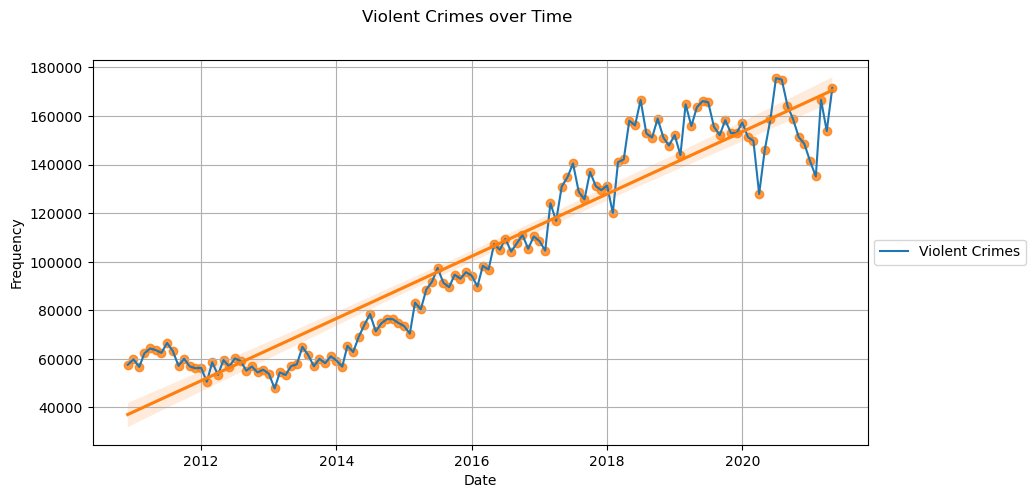

In [23]:
df_violence_timeseries2 = df_violence_timeseries.reset_index()

# Displays the violence timeseries as a line graph.
# Suitable labels, title, grid, and legend are used.
# seaborn's regplot is used for a line of best fit.

fig, ax = plt.subplots()
ax.set_xlabel("Date")
ax.set_ylabel("Frequency")
ax.grid()
ax.plot(df_violence_timeseries2.Date, df_violence_timeseries2.Frequency)
ax.legend(["Violent Crimes"], loc='center left',bbox_to_anchor=(1.0, 0.5))

df_violence_timeseries2.Date = df_violence_timeseries2.Date.apply(date2num)
regplot(x = df_violence_timeseries2.Date, y = df_violence_timeseries2.Frequency)

fig.suptitle("Violent Crimes over Time")
fig.set_size_inches(10, 5)
plt.show()

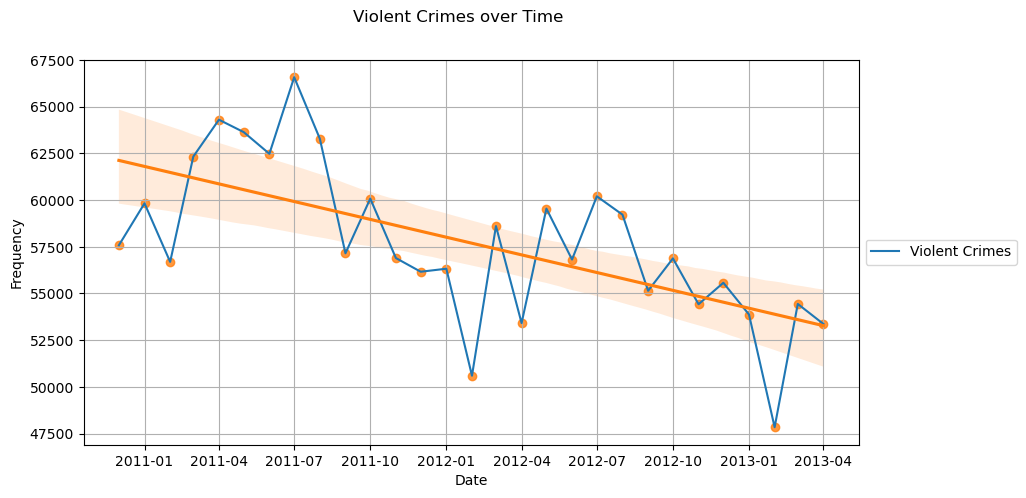

In [24]:
df_violence_timeseries3 = df_just_violence_timeseries.reset_index()

# Displays the violence timeseries as a line graph.
# Suitable labels, title, grid, and legend are used.
# seaborn's regplot is used for a line of best fit.

fig, ax = plt.subplots()
ax.set_xlabel("Date")
ax.set_ylabel("Frequency")
ax.grid()
ax.plot(df_violence_timeseries3.Date, df_violence_timeseries3.Frequency)
ax.legend(["Violent Crimes"], loc='center left',bbox_to_anchor=(1.0, 0.5))

df_violence_timeseries3.Date = df_violence_timeseries3.Date.apply(date2num)
regplot(x = df_violence_timeseries3.Date, y = df_violence_timeseries3.Frequency)

fig.suptitle("Violent Crimes over Time")
fig.set_size_inches(10, 5)
plt.show()

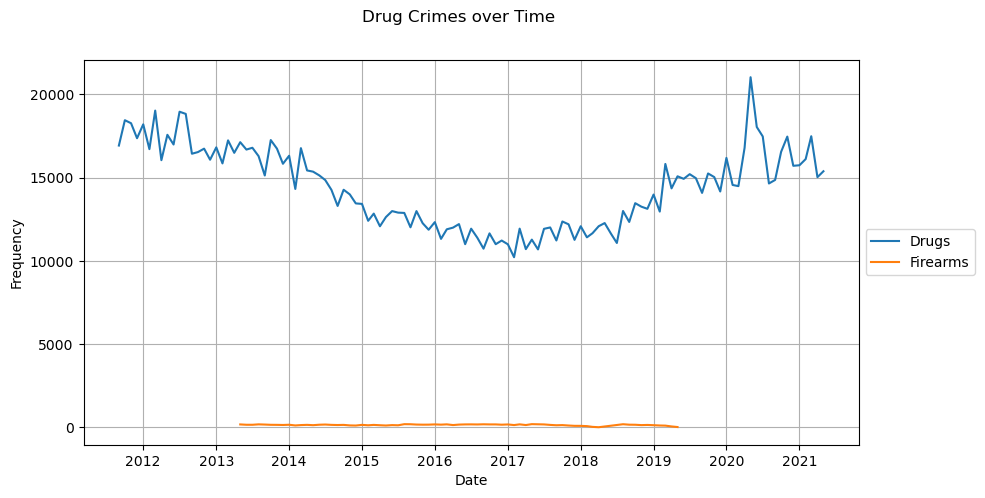

In [25]:
# Displays the drugs and firearms timeseries' as a line graph.
# Suitable labels, title, grid, and legend are used.

fig, ax = plt.subplots()
ax.set_xlabel("Date")
ax.set_ylabel("Frequency")
ax.grid()
ax.plot(df_drugs_timeseries)
ax.plot(df_firearms_timeseries)
ax.legend(["Drugs", "Firearms"], loc='center left',bbox_to_anchor=(1.0, 0.5))

fig.suptitle("Drug Crimes over Time")
fig.set_size_inches(10, 5)
plt.show()

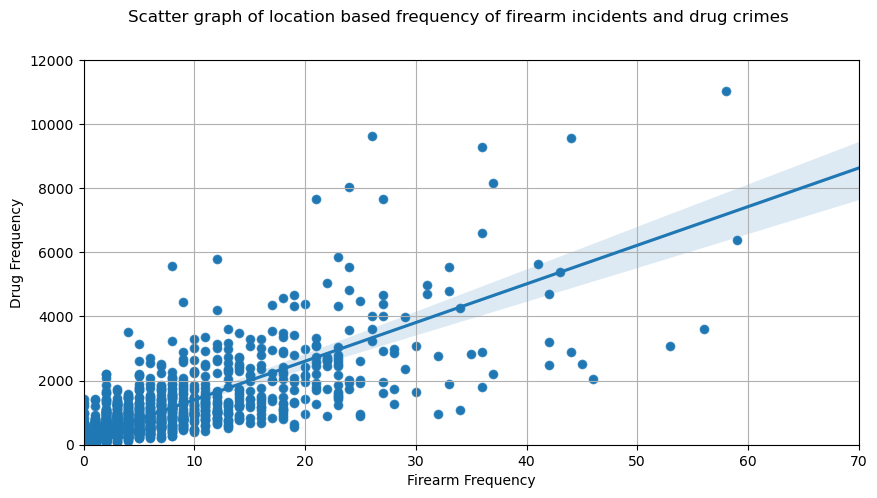

In [26]:
fig, ax = plt.subplots()

df_postcode_frequency_pd.plot(x = "Firearm_Frequency", y = "Drug_Frequency", ax=ax, kind="scatter")
regplot(x = df_postcode_frequency_pd.Firearm_Frequency, y = df_postcode_frequency_pd.Drug_Frequency)

ax.grid()
ax.set_xlabel("Firearm Frequency")
ax.set_ylabel("Drug Frequency")
ax.set_xlim(0,70)
ax.set_ylim(0,12000)

fig.suptitle("Scatter graph of location based frequency of firearm incidents and drug crimes")
fig.set_size_inches(10, 5)
plt.show()

In [27]:
print("Total Incidents of both firearms and drugs at the same location in the same timeframe: {0}" \
      .format(df_correlation_Date_Long_Lat.count()))

Total Incidents of both firearms and drugs at the same location in the same timeframe: 4768


In [28]:
# Displays the same dataframe of firearm incidents in each district across the UK
# First display is sorted by the highest number of incidents per head in the UK, as the claim states

print("Districts with the highest number of incidents per 100,000 people:")
df_firearm_incidents_district = df_firearm_incidents_district.sort_values("Incidents Per 100,000 People", ascending=False)
display(df_firearm_incidents_district)
birmingham_rank = df_firearm_incidents_district.index[df_firearm_incidents_district['District']=="Birmingham"] \
                                .tolist()[0] + 1
total_districts = df_firearm_incidents_district.count()["District"]
percentile = round((1 - ((birmingham_rank - 1) / total_districts)) * 100)
print("Birmingham ranks number {0} out of all {1} districts with firearm incidents".format(birmingham_rank, total_districts))

# Second display shows Birminghams ranking in this dataframe, as well as a few districts with similar levels
display(df_firearm_incidents_district[birmingham_rank-3:birmingham_rank+2])

# Third display shows the districts with the highest number of total incidents
print("Districts with the highest number of incidents:")
df_firearm_incidents_district = df_firearm_incidents_district.sort_values("Incidents", ascending=False)
display(df_firearm_incidents_district)

# Fourth display shows the districts with the highest total population.
print("Districts with the highest population:")
df_firearm_incidents_district = df_firearm_incidents_district.sort_values("Population", ascending=False)
display(df_firearm_incidents_district)

Districts with the highest number of incidents per 100,000 people:


,District,Incidents,Population,"Incidents Per 100,000 People"
0,City of London,17,7355,231.13528
1,North Devon,144,93666,153.73775
2,North Somerset,224,202592,110.56705
3,West Somerset,27,34655,77.91084
4,Westminster,162,219361,73.85087
...,...,...,...,...
315,Windsor and Maidenhead,2,144646,1.38269
316,Wealden,2,148913,1.34307
317,Runnymede,1,80448,1.24304
318,Blaby,1,93784,1.06628


Birmingham ranks number 83 out of all 320 districts with firearm incidents


,District,Incidents,Population,"Incidents Per 100,000 People"
80,Hastings,20,90111,22.19485
81,Bassetlaw,25,112850,22.15330
82,Birmingham,237,1072849,22.09071
83,Reading,34,155715,21.83476
84,Bury,40,185045,21.61636


Districts with the highest number of incidents:


,District,Incidents,Population,"Incidents Per 100,000 People"
82,Birmingham,237,1072849,22.09071
2,North Somerset,224,202592,110.56705
65,Leeds,199,751490,26.48072
23,Liverpool,176,466337,37.74095
4,Westminster,162,219361,73.85087
...,...,...,...,...
297,Adur,2,61167,3.26974
289,Craven,2,55429,3.60822
317,Runnymede,1,80448,1.24304
318,Blaby,1,93784,1.06628


Districts with the highest population:


,District,Incidents,Population,"Incidents Per 100,000 People"
82,Birmingham,237,1072849,22.09071
65,Leeds,199,751490,26.48072
51,Sheffield,157,552744,28.40375
163,Cornwall,70,532285,13.15085
72,Bradford,123,522428,23.54391
...,...,...,...,...
282,Melton,2,50349,3.97227
280,Christchurch,2,47726,4.19059
265,Rutland,2,37380,5.35045
3,West Somerset,27,34655,77.91084


The first graph suggests a very strong positive linear correlation in the violent crime timeseries. While the data does fluctuate month-by-month and year-by-year, there remains a very prevalent upwards trend that violent crime in the UK is increasing based on this data, with the first sample being below 60,000 violent crimes, and the last reaching over 170,000 violent crimes in a single month. The second graph is a plot of only the data labelled "Violent crime", rather than both "Violent crime" and "Violence and sexual offences". This shows a trend that violent crime was actually decreasing prior to the inclusion of sexual offences.

The third graph plots a timeseries of drugs and firearms on the same axis, however, there exists a large disparity between the frequency of drug offences compared to firearm incidents. Firearm incidents seem to have remained stable at a very low frequency, whereas drug use began much higher, steadily decreasing until around 2017 where it has been increasing to a similar level as it began in 2012. As the graph was not very insightful, a data frame of firearm and drug offences at the same location during the same month was created. It was found that of the 10,122 firearm incidents, there was 4,768 drug incidents at the same location during the same month. While this could be a coincidence given the 1,636,770 total drug incidents, it should be considered when drawing conclusions on the claims with the limited data, as there is no way to verify the offences are actually related without the identity of the offender(s).

Lastly, the firearm incidents per population suggests that Birmingham does not have the highest firearms incidents per head, but rather the City of London, North Devon, and North Somerset rank highest, all with an average of over 100 incidents per 100,000 people. Birmingham is ranked number 83 out of all UK districts, with less than 23 incidents per 100,000 people. On the other hand, Birmingham does have the highest total number of firearm incidents than any other district, however, this is offset in the per-population statistic as they also have the highest population of any single district.

# 5) Selection, application, and reasoning behind use of statistical analysis and multiple evaluation measures   _markdown_, _code_,  _markdown_, 20 Marks

As in the previous section,
1. Explain what you are trying to do (with references)
2. Do the coding and include the results
3. Explain your findings.

For the violent crime data timeseries, the data was expected to be linear after the line of best fit appeared to maintain a relatively small error against the data points. Therefore, Pearson’s algorithm was used for this as it is effective on linear data and provides both a correlation coefficient and p value [4, 5]. The correlation coefficient is the strength of the correlation, as well as if it is positive or negative, and the p value is the probability that the same correlation could occur if the null hypothesis was true. Conventionally, a p value lower than 0.05, or 5%, is regarded as statistically significant and suggests that the null hypothesis is false. The null hypothesis assumes that no relationship at all exists, and that the variables are completely independent of one another [4]. This is assumed to be true during statistical analysis, for the purpose of disproving it based on the probability of it occurring, and therefore proving the alternate hypothesis more likely true – that the variables are correlated [4].

As for measuring if firearms incidents are associated with drug offences, this relationship is assumed to be non-linear and therefore Spearman’s algorithm will be used [6]. Spearman’s algorithm is like Pearson’s algorithm in that both provide a correlation coefficient and a p value, with the primary difference being Spearman’s algorithm can be applied to unnormalized data.

Lastly, no particular statistical analysis should be required to answer whether Birmingham has the greatest number of firearms incidents per population, and very basic statistical functions will be used for this instead. This includes listing the districts with the highest incidents per population in order, finding where Birmingham ranks in this list, and its’ percentile against other districts.


In [29]:
#get min and max frequencies
minFreq = df_violence_timeseries2.Frequency.min()
maxFreq = df_violence_timeseries2.Frequency.max()

#normalise the data for the pearson function
df_violence_timeseries2 = df_violence_timeseries2.assign(normalised=(df_violence_timeseries2.Frequency - minFreq) / (maxFreq - minFreq))

#declare X and Y variables for correlation
Y = df_violence_timeseries2.normalised
X = df_violence_timeseries2.index

#find correlation
violence_model = pearsonr(X, Y)
#display correlation data
print(violence_model)

PearsonRResult(statistic=0.9493135558432482, pvalue=3.5688277825928895e-64)


In [30]:
print("Birmingham is in the {0}th percentile, making it in the top {1}% of districts for firearm incidents per 100,000 people in the UK" \
     .format(percentile, 100 - percentile))

Birmingham is in the 74th percentile, making it in the top 26% of districts for firearm incidents per 100,000 people in the UK


In [31]:
# declare X and Y values for correlation
Y = df_postcode_frequency_pd["Drug_Frequency"]
X = df_postcode_frequency_pd["Firearm_Frequency"]

# find correlation using the spearman algorithm
drug_firearm_model = spearmanr(X, Y)
#display correlation data
drug_firearm_model

SpearmanrResult(correlation=0.8240953816150007, pvalue=0.0)

In [32]:
print("Percentage of firearm offences that coincide with drug offences: {0}%".format(round((num_correlated_offences / num_firearm_offences) * 100, 2)))
print("Percentage of drug offences that coincide with firearms offences: {0}%".format(round((num_correlated_offences / num_drug_offences) * 100, 2)))

Percentage of firearm offences that coincide with drug offences: 47.11%
Percentage of drug offences that coincide with firearms offences: 0.29%


The Pearson correlation statistic for the violent crime data timeseries was extremely strong, with a correlation coefficient of 0.95 and a p value of 3.6 x10-64. The correlation coefficient is very close to 1, indicating an extremely strong, positive correlation between time and frequency. The p value, or probability of this result if the null hypothesis was correct, is very low, indicating that the data are strongly correlated, and therefore supporting the claim that violent crime is both strongly correlated with time and is increasing. 

As for firearm incidents per population in Birmingham, it does not have the highest firearm incidents per population than any other district, but rather ranks number 83 out of all 320 districts with firearm incidents. Only districts with at least 1 firearm incident on record were included in this analysis, which puts Birmingham in the 74th percentile, or in the top 26% for firearm incidents per population. Interestingly, Birmingham did have the highest number of total firearms incidents, however, having also the highest population of any single district, this was significantly reduced when analysing incidents per population.

Lastly, Spearman’s algorithm was used to determine if firearm incidents were associated with drug offences and was found to be statistically very likely. Spearman’s algorithm provides both a correlation coefficient and a p value, which both supported this claim. The correlation coefficient was 0.82, suggesting a very strong correlation between firearm incidents and drug offences. The p value, like in Pearson’s algorithm, is the probability of this occurring given the null hypothesis is true.  The calculated p value was found to be 0.0, suggesting a very strong relationship between firearm and drug offences, and a near-impossible chance of it randomly occurring were they not correlated.

# 6) Detailed Analysis and consideration of the appropriateness of the solution for the initial problem  _markdown_, 10 Marks

This is the discussion section of you report. You should critically consider the advantages, disadvantages, and limitations of the methods used. 

One advantage of the methodology was that the data used was provided by the UK Government and therefore should be free of bias. It is in the Government's interest to appear to have less crime, however, Government statistics are independently reviewed by non-political organisations and are therefore more reliable [7].

One limitation of the methodology is that only crimes that have been reported are included in the crime dataset. For example, the data suggests a large increase in violent crime, however, it is also possible that the actual amount of crime has stayed the same, and the increase is due to more of the violent crimes being reported.

A second limitation is that in 2013, violent crimes was no longer an individual crime type, but rather included in violent and sexual offences. This means that any sexual offences that were not also violent crimes would be considered violent crimes in this application. The data also suggests this, as the data does not drastically increase until during 2013 when the crime type is changed. When only data for violent crimes is plotted, rather than together with violence and sexual offences, the data shows a negative correlation, indicating that violence was decreasing before sexual offences were included, where it increased drastically thereafter. This leads to a less reliable conclusion about the trends observed and claims made.

One limitation to the firearm data is that there are significantly fewer firearm incidents in the UK than drug offences. This difference makes it challenging to determine if one is influencing the other despite the very strong correlation shown during the statistical analysis of the data. It is also unknown in the dataset if multiple crimes are recorded, or if the more serious crime takes priority. This means that firearm offences could have also been drug offences, but the firearm is more serious and therefore causes the drug offence to be disregarded. This is further made difficult as the dataset does not provide a method of identifying the offender, and therefore it cannot be known with certainty that one offence corresponds with another, or if there merely exists a correlation in location to those particular crimes. However, the documentary does not claim that firearm offenders are also drug offenders, but rather that firearms incidents are associated with drug offences, which the data entirely supports. 

The correlation for firearm and drug incidents was found on a per-area basis on the respective crimes that fall within the first half of a postcode. Time was not used as the individual offender was not in question, but rather if the crimes are associated. This was taken to mean that a single offender need not commit both offences, but just that the offences were associated via their area, which was found to be strongly correlated. Location coordinates or a complete postcode were not used as they were believed to be too specific and would therefore not produce a correlation at all. This is because a small number of houses in a complete postcode, or a single house in a coordinate pair, was thought to not constitute a large enough area to identify any trends with the relatively low number of total firearm incidents across the country.


# 7) Evaluation and Conclusion  _markdown_, 10 Marks

In the conclusion you should consider you initial aim and objectives and discuss your findings. Specifically you need to advice your client insurance company.

To conclude, the investigation suggests that violent crime is increasing, that the district of Birmingham does not have the highest frequency of firearm incidents per head than any other district, and that firearm incidents are associated with drug offences.

Reported violent crime in the UK has been increasing at an alarming rate since 2013, and while this may be due in part to the inclusion of non-violent sexual offences, it is very unlikely that this was the sole reasoning behind this trend, and the much more obvious indicator being that violent crime itself is increasing, or at minimum, more reports of violent crime are being made. This could be for several reasons, such as reduced stigma around reporting violence, but the causality itself is outside of the scope of this investigation.

As for firearm incidents per district population, Birmingham does not rank highest in this dataset, but rather 83rd. Birmingham does rank highest in total firearm incidents as well as population, however, the claim specifically mentions “per head”, and therefore these datasets prove the claim to be false.

Lastly in regard to firearm incidents and drug offences, the data suggests a very strong positive correlation that supports the claim that the offences are closely associated with one another. Of the three claims, this is the weakest confirmation, however, without further analysis of other more sensitive datasets out of the scope of this investigation, it is not possible to better determine causality, and by extension, association. Future work may consist of using the identity of the offender, as well as the circumstance of the crime to better determine an association. The offender identity itself cannot fully explore this; as for example, one offender may have a firearm offence directly committed as a result of another offenders’ drug offence, making the crimes associated but with different offenders that would not be detected.


# 8) References and Citation _markdown_, 10 Marks

References are essential at level 7. in this section you should give references for the papers/books you have cited in this assignment. Try to avoid using web pages as these are considered _weak references_ as they are often not reviewed.

[1]	A. Roman-Urrestarazu et al., "Brexit threatens the UK’s ability to tackle illicit drugs and organised crime: What needs to happen now?," Health Policy, vol. 123, no. 6, pp. 521-525, 2019/06/01/ 2019, doi: https://doi.org/10.1016/j.healthpol.2019.04.005.


[2]	J. Rehm, R. Room, W. van den Brinkt, and L. Kraus, "Problematic drug use and drug use disorders in EU countries and Norway: An overview of the epidemiology," European Neuropsychopharmacology, vol. 15, no. 4, pp. 389-397, 2005/08/01/ 2005, doi: https://doi.org/10.1016/j.euroneuro.2005.04.004.


[3]	P. Reuter and A. Stevens, "An Analysis of UK Drug Policy A Monograph Prepared for the UK Drug Policy Commission," 01/01 2007.

[4]	P. Sedgwick, "Pearson's correlation coefficient," (in English), BMJ : British Medical Journal (Online), vol. 345, 2012 Jul 04, 2021-07-19 2012, doi: https://doi.org/10.1136/bmj.e4483.

[5]	K. R. Godfrey, "Correlation methods," Automatica, vol. 16, no. 5, pp. 527-534, 1980/09/01/ 1980, doi: https://doi.org/10.1016/0005-1098(80)90076-X.


[6]	P. Sedgwick, "Spearman's rank correlation coefficient," (in English), BMJ : British Medical Journal (Online), vol. 349, 2014 Nov 28, 2016-10-31 2014, doi: https://doi.org/10.1136/bmj.g7327.

[7]	T. U. S. System. "The UK Statistical System." (accessed 22/11/2022.)

